In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.decomposition import PCA
from matplotlib.dates import DateFormatter
import os
import pytz
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

/Users/yagmurozdemir/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


The data file we use has these pre-processing steps done:
1. the rows where 'suspended' or 'stopped' columns take value 'True' has filtered out from the dataset.
2. For filling of the NA values, firstly the data is grouped into separate dataframes according to the fixture_id. Then, all matches are sorted according to time and NA values are filled with the values above (meaning information from already happened events are used for the filling). 
3. Then, any remaining NA values are filled with 0. 

On this notebook, we  use the data where we have already applied this preprocessing steps.



In [2]:
data_path = '/Users/yagmurozdemir/Desktop'
data = pd.read_csv(os.path.join(data_path, 'filled_match_groups_2.csv'))

df = data.copy()

df

fixture_id  halftime         current_time  half_start_datetime  \
0      19134453.0  1st-half  2024-08-16 19:01:19  2024-08-16 19:00:31   
1      19134453.0  1st-half  2024-08-16 19:02:18  2024-08-16 19:00:31   
2      19134453.0  1st-half  2024-08-16 19:03:19  2024-08-16 19:00:31   
3      19134453.0  1st-half  2024-08-16 19:04:18  2024-08-16 19:00:31   
4      19134453.0  1st-half  2024-08-16 19:05:19  2024-08-16 19:00:31   
...           ...       ...                  ...                  ...   
63900  19172117.0  2nd-half  2024-11-10 18:03:41  2024-11-10 17:15:56   
63901  19172117.0  2nd-half  2024-11-10 18:04:41  2024-11-10 17:15:56   
63902  19172117.0  2nd-half  2024-11-10 18:05:41  2024-11-10 17:15:56   
63903  19172117.0  2nd-half  2024-11-10 18:06:41  2024-11-10 17:15:56   
63904  19172117.0  2nd-half  2024-11-10 18:07:43  2024-11-10 17:15:56   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
0      2024-08-16 19:00:31       0      48     2024-08-16 19:01:17      False   
1      2024-08-16 19:00:31       1      47     2024-08-16 19:02:16      False   
2      2024-08-16 19:00:31       2      48     2024-08-16 19:03:15      False   
3      2024-08-16 19:00:31       3      47     2024-08-16 19:04:08      False   
4      2024-08-16 19:00:31       4      48     2024-08-16 19:05:15      False   
...                    ...     ...     ...                     ...        ...   
63900  2024-11-10 16:03:27      47      45     2024-11-10 17:52:39       True   
63901  2024-11-10 16:03:27      48      45     2024-11-10 17:52:39       True   
63902  2024-11-10 16:03:27      49      45     2024-11-10 17:52:39       True   
63903  2024-11-10 16:03:27      50      45     2024-11-10 17:52:39       True   
63904  2024-11-10 16:03:27      51      47     2024-11-10 17:52:39       True   

       stopped  ...  Throwins - home  Total Crosses - away  \
0        False  ...              0.0                   0.0   
1        False  ...              0.0                   0.0   
2        False  ...              0.0                   0.0   
3        False  ...              0.0                   0.0   
4        False  ...              0.0                   0.0   
...        ...  ...              ...                   ...   
63900     True  ...             13.0                  16.0   
63901     True  ...             14.0                  16.0   
63902     True  ...             14.0                  16.0   
63903     True  ...             14.0                  17.0   
63904     True  ...             14.0                  17.0   

       Total Crosses - home Yellowcards - away  Yellowcards - home  \
0                       0.0                0.0                 0.0   
1                       0.0                0.0                 0.0   
2                       0.0                0.0                 0.0   
3                       0.0                0.0                 0.0   
4                       0.0                0.0                 0.0   
...                     ...                ...                 ...   
63900                  23.0                6.0                 1.0   
63901                  23.0                6.0                 1.0   
63902                  23.0                6.0                 1.0   
63903                  23.0                6.0                 1.0   
63904                  23.0                6.0                 1.0   

       Yellowred Cards - away  Yellowred Cards - home  current_state  \
0                         0.0                     0.0              0   
1                         0.0                     0.0              0   
2                         0.0                     0.0              0   
3                         0.0                     0.0              0   
4                         0.0                     0.0              0   
...                       ...                     ...            ...   
63900                     0.0                     0.0              

## data analysis

In [3]:
## for this analysis only the periods defined as training is used.
analysis_df = df[df["match_start_datetime"] < "2024-11-01"]
analysis_df

fixture_id  halftime         current_time  half_start_datetime  \
0      19134453.0  1st-half  2024-08-16 19:01:19  2024-08-16 19:00:31   
1      19134453.0  1st-half  2024-08-16 19:02:18  2024-08-16 19:00:31   
2      19134453.0  1st-half  2024-08-16 19:03:19  2024-08-16 19:00:31   
3      19134453.0  1st-half  2024-08-16 19:04:18  2024-08-16 19:00:31   
4      19134453.0  1st-half  2024-08-16 19:05:19  2024-08-16 19:00:31   
...           ...       ...                  ...                  ...   
62068  19172099.0  2nd-half  2024-10-27 17:58:41  2024-10-27 17:13:55   
62069  19172099.0  2nd-half  2024-10-27 17:59:41  2024-10-27 17:13:55   
62070  19172099.0  2nd-half  2024-10-27 18:00:41  2024-10-27 17:13:55   
62071  19172099.0  2nd-half  2024-10-27 18:01:41  2024-10-27 17:13:55   
62072  19172099.0  2nd-half  2024-10-27 18:02:41  2024-10-27 17:13:55   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
0      2024-08-16 19:00:31       0      48     2024-08-16 19:01:17      False   
1      2024-08-16 19:00:31       1      47     2024-08-16 19:02:16      False   
2      2024-08-16 19:00:31       2      48     2024-08-16 19:03:15      False   
3      2024-08-16 19:00:31       3      47     2024-08-16 19:04:08      False   
4      2024-08-16 19:00:31       4      48     2024-08-16 19:05:15      False   
...                    ...     ...     ...                     ...        ...   
62068  2024-10-27 16:06:53      44      46     2024-10-27 17:53:07       True   
62069  2024-10-27 16:06:53      45      46     2024-10-27 17:53:07       True   
62070  2024-10-27 16:06:53      46      46     2024-10-27 17:53:07       True   
62071  2024-10-27 16:06:53      47      46     2024-10-27 17:53:07       True   
62072  2024-10-27 16:06:53      48      46     2024-10-27 17:53:07       True   

       stopped  ...  Throwins - home  Total Crosses - away  \
0        False  ...              0.0                   0.0   
1        False  ...              0.0                   0.0   
2        False  ...              0.0                   0.0   
3        False  ...              0.0                   0.0   
4        False  ...              0.0                   0.0   
...        ...  ...              ...                   ...   
62068     True  ...             20.0                   6.0   
62069     True  ...             20.0                   6.0   
62070     True  ...             20.0                   6.0   
62071     True  ...             20.0                   6.0   
62072     True  ...             20.0                   6.0   

       Total Crosses - home Yellowcards - away  Yellowcards - home  \
0                       0.0                0.0                 0.0   
1                       0.0                0.0                 0.0   
2                       0.0                0.0                 0.0   
3                       0.0                0.0                 0.0   
4                       0.0                0.0                 0.0   
...                     ...                ...                 ...   
62068                  26.0                1.0                 2.0   
62069                  26.0                1.0                 2.0   
62070                  26.0                1.0                 2.0   
62071                  26.0                1.0                 2.0   
62072                  28.0                1.0                 2.0   

       Yellowred Cards - away  Yellowred Cards - home  current_state  \
0                         0.0                     0.0              0   
1                         0.0                     0.0              0   
2                         0.0                     0.0              0   
3                         0.0                     0.0              0   
4                         0.0                     0.0              0   
...                       ...                     ...            ...   
62068                     0.0                     0.0              

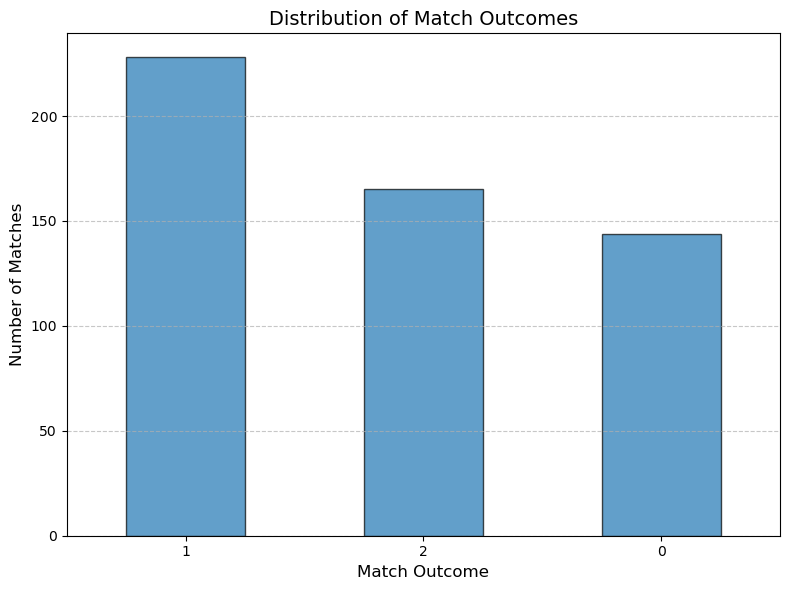

In [4]:

# drop duplicates to ensure each match is evaluated only once
unique_matches = analysis_df.drop_duplicates(subset=['fixture_id'])

result_counts = unique_matches['result'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
result_counts.plot(kind='bar', alpha=0.7, edgecolor='black')
plt.title('Distribution of Match Outcomes', fontsize=14)
plt.xlabel('Match Outcome', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6229/4286711482.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_matches = sample_matches.groupby("result").apply(lambda x: x.sample(n=min(3, len(x)), random_state=42)).reset_index(drop=True)


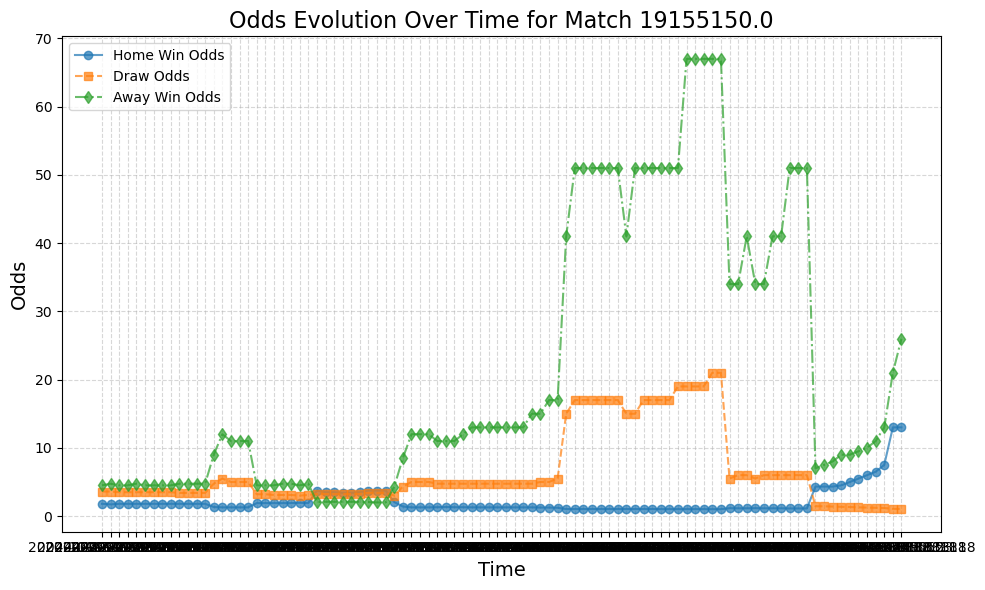

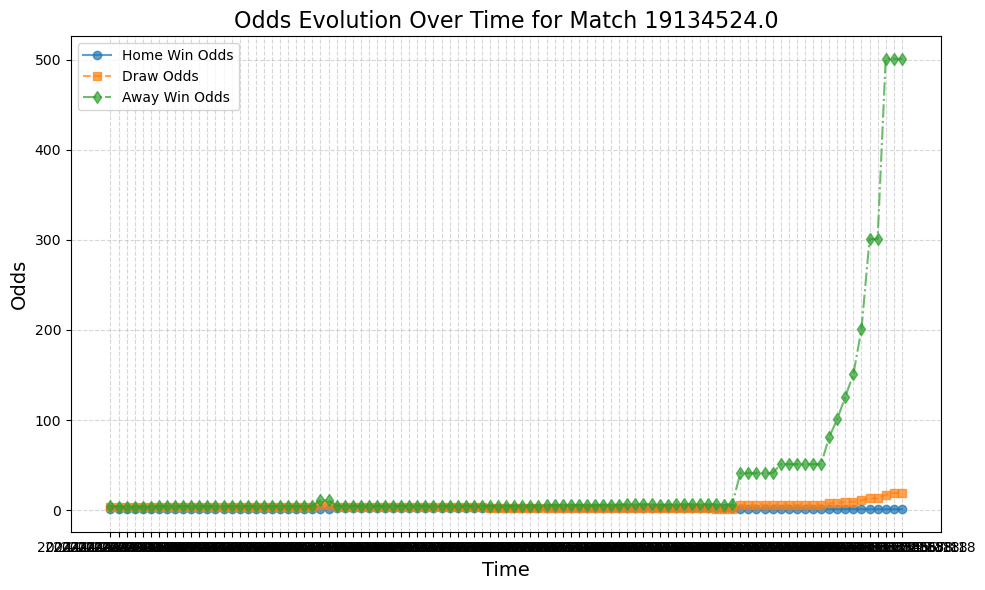

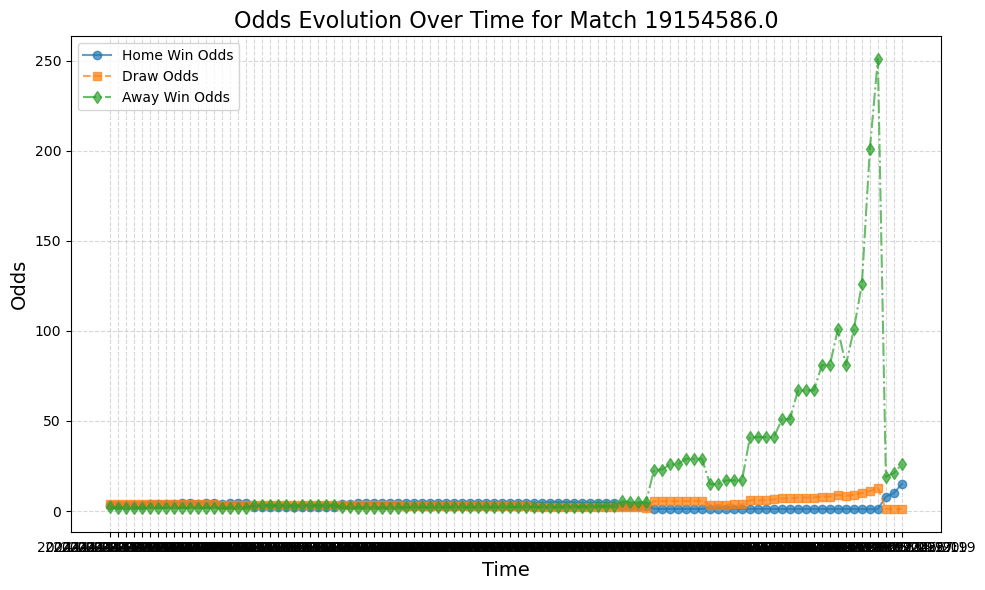

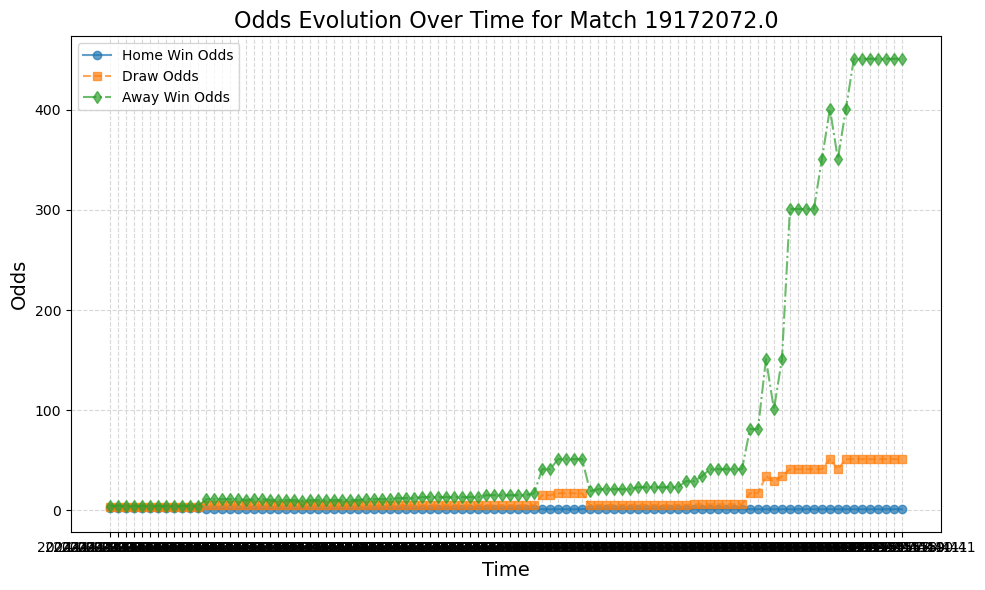

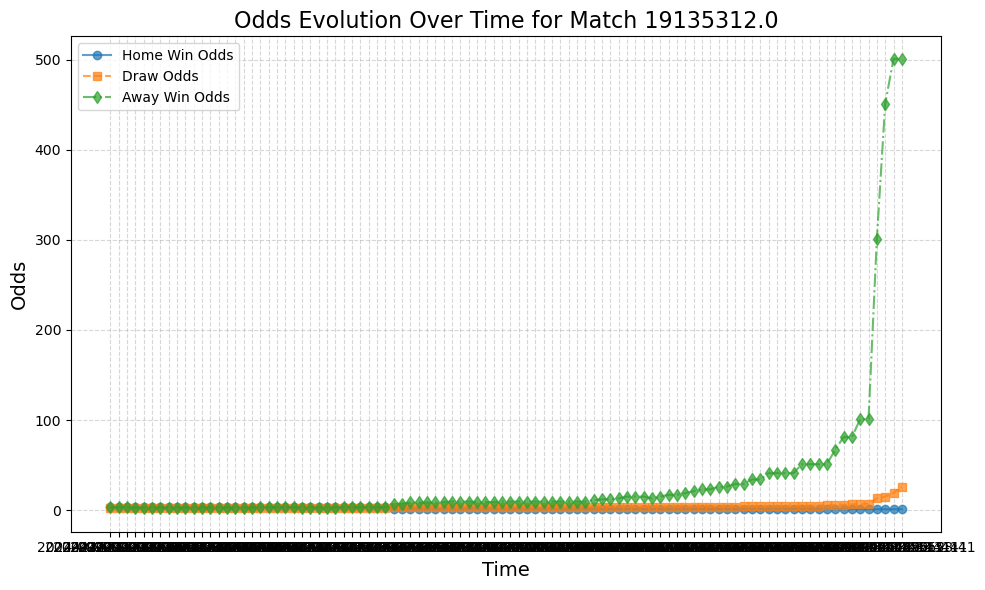

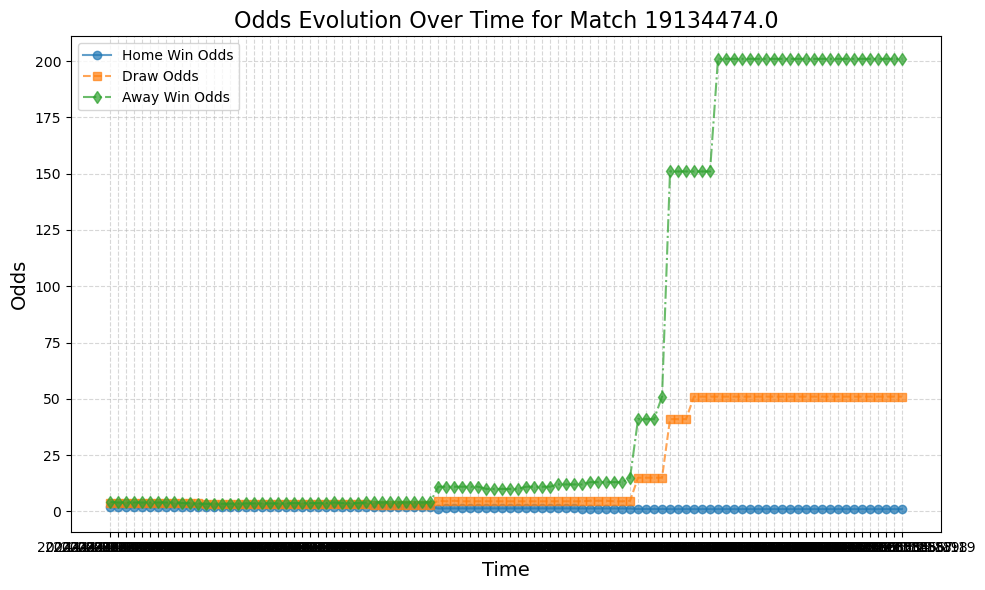

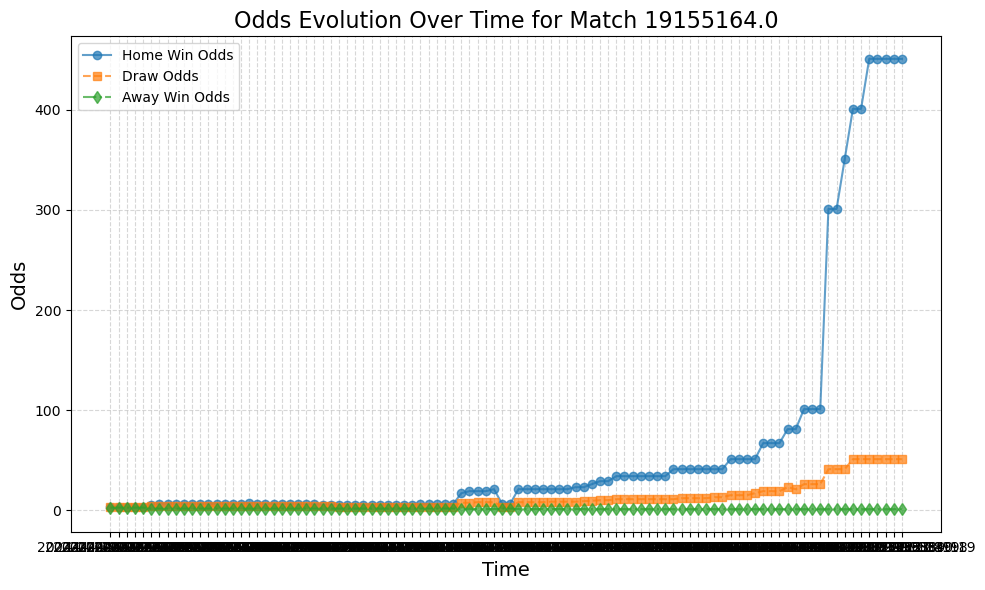

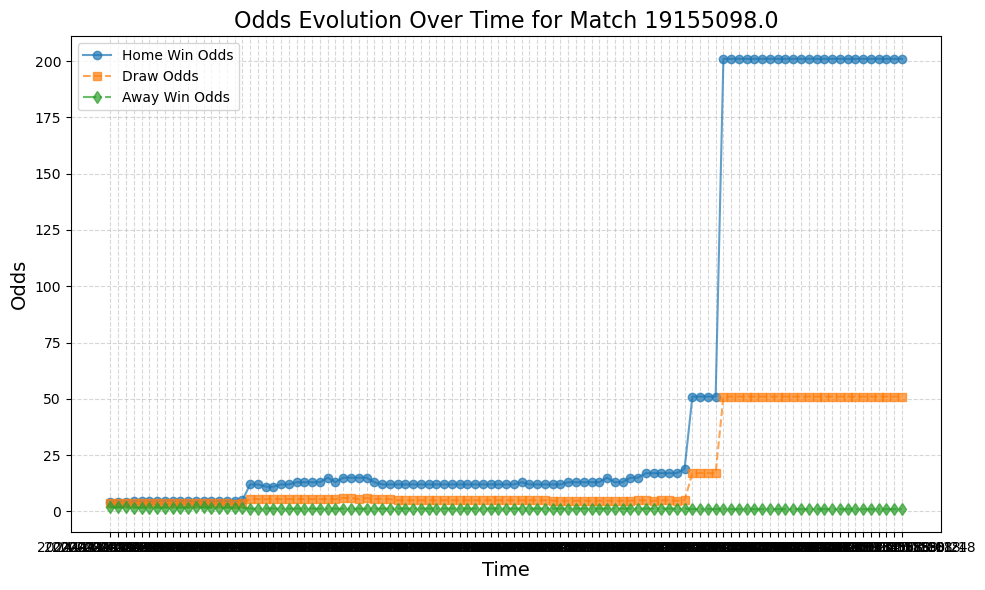

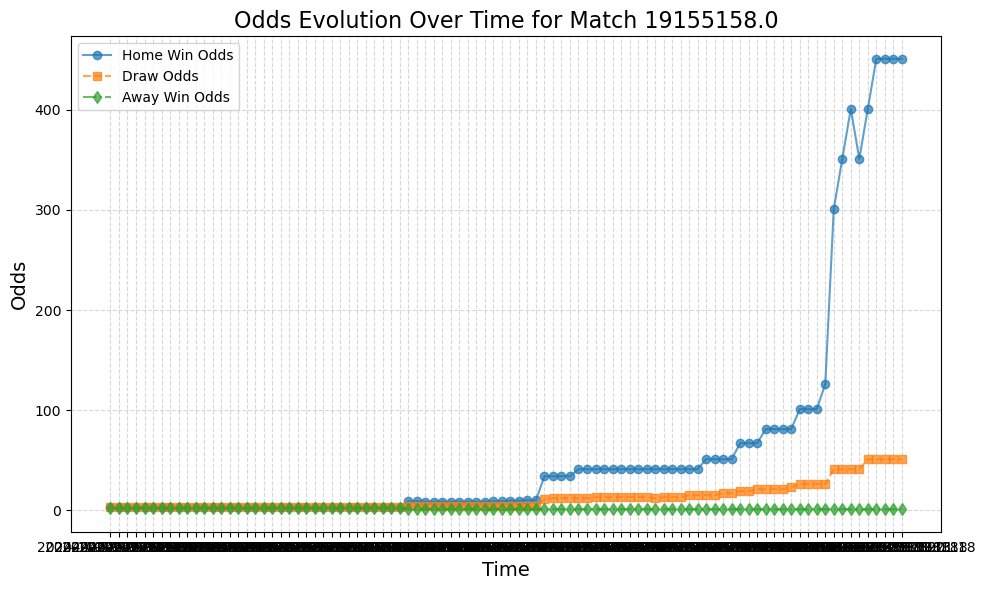

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# selecting matches for each result category (1: Home win, 0: Draw, 2: Away win)
sample_matches = analysis_df.drop_duplicates(subset=["fixture_id"])
sample_matches = sample_matches.groupby("result").apply(lambda x: x.sample(n=min(3, len(x)), random_state=42)).reset_index(drop=True)

required_columns = ["current_time", "1", "X", "2"]
missing_columns = [col for col in required_columns if col not in analysis_df.columns]
if missing_columns:
    raise KeyError(f"The following required columns are missing from the dataset: {missing_columns}")

# Generate separate plots for each selected match
for idx, row in sample_matches.iterrows():
    match_data = analysis_df[analysis_df["fixture_id"] == row["fixture_id"]]

    plt.figure(figsize=(10, 6))
    plt.plot(match_data["current_time"], match_data["1"], label="Home Win Odds", linestyle='-', marker='o', alpha=0.7)
    plt.plot(match_data["current_time"], match_data["X"], label="Draw Odds", linestyle='--', marker='s', alpha=0.7)
    plt.plot(match_data["current_time"], match_data["2"], label="Away Win Odds", linestyle='-.', marker='d', alpha=0.7)

    plt.title(f"Odds Evolution Over Time for Match {row['fixture_id']}", fontsize=16)
    plt.xlabel("Time", fontsize=14)
    plt.ylabel("Odds", fontsize=14)
    plt.legend(loc="upper left", fontsize=10)
    plt.grid(axis='both', linestyle='--', alpha=0.5)
    plt.tight_layout()

    plt.show()


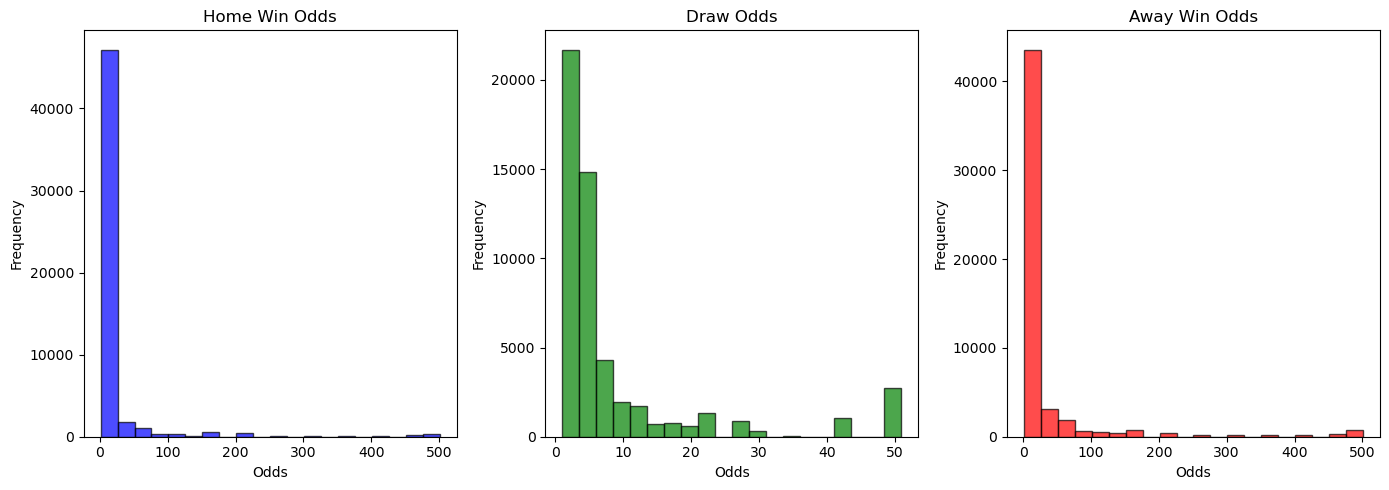

In [6]:
# Plot histograms for odds
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
analysis_df['1'].plot(kind='hist', bins=20, alpha=0.7, color='blue', edgecolor='black', title="Home Win Odds")
plt.xlabel("Odds")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
analysis_df['X'].plot(kind='hist', bins=20, alpha=0.7, color='green', edgecolor='black', title="Draw Odds")
plt.xlabel("Odds")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
analysis_df['2'].plot(kind='hist', bins=20, alpha=0.7, color='red', edgecolor='black', title="Away Win Odds")
plt.xlabel("Odds")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


/var/folders/ff/x1vnwffx7w54w1yt78lv97gm0000gn/T/ipykernel_6229/1291379066.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df['cumulative_minute'] = analysis_df.apply(


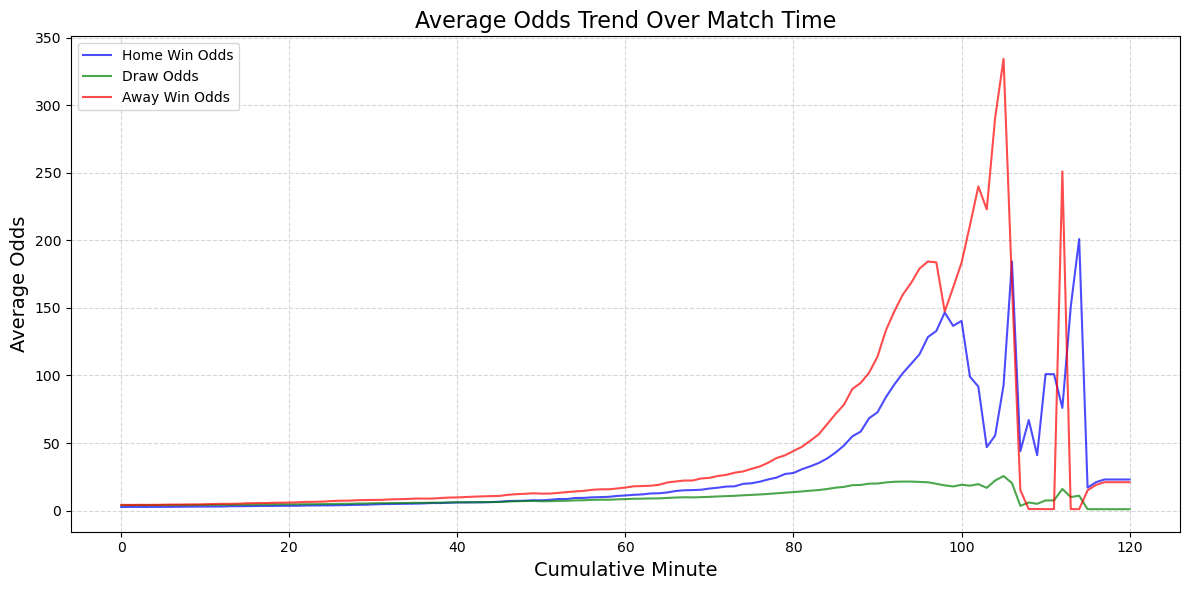

In [7]:
## odds trends' by averaging according to the minute info
analysis_df['cumulative_minute'] = analysis_df.apply(
    lambda row: row['minute'] if row['halftime'] == '1st-half' else row['minute'] + 45, axis=1
)

# group by cumulative minute and calculate average odds
odds_trend = analysis_df.groupby("cumulative_minute")[["1", "X", "2"]].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(odds_trend.index, odds_trend["1"], label="Home Win Odds", color='blue', alpha=0.7)
plt.plot(odds_trend.index, odds_trend["X"], label="Draw Odds", color='green', alpha=0.7)
plt.plot(odds_trend.index, odds_trend["2"], label="Away Win Odds", color='red', alpha=0.7)
plt.title("Average Odds Trend Over Match Time", fontsize=16)
plt.xlabel("Cumulative Minute", fontsize=14)
plt.ylabel("Average Odds", fontsize=14)
plt.legend(loc="upper left", fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## benchmark model

In [8]:
#calculating the implied probabilities
df['P_home'] = 1 / df['1']
df['P_draw'] = 1 / df['X']
df['P_away'] = 1 / df['2']


#normalizing the probabilities
df['P_sum'] = df['P_home'] + df['P_draw'] + df['P_away']
df['P_home_normalized'] = df['P_home'] / df['P_sum']
df['P_draw_normalized'] = df['P_draw'] / df['P_sum']
df['P_away_normalized'] = df['P_away'] / df['P_sum']




In [9]:
df

fixture_id  halftime         current_time  half_start_datetime  \
0      19134453.0  1st-half  2024-08-16 19:01:19  2024-08-16 19:00:31   
1      19134453.0  1st-half  2024-08-16 19:02:18  2024-08-16 19:00:31   
2      19134453.0  1st-half  2024-08-16 19:03:19  2024-08-16 19:00:31   
3      19134453.0  1st-half  2024-08-16 19:04:18  2024-08-16 19:00:31   
4      19134453.0  1st-half  2024-08-16 19:05:19  2024-08-16 19:00:31   
...           ...       ...                  ...                  ...   
63900  19172117.0  2nd-half  2024-11-10 18:03:41  2024-11-10 17:15:56   
63901  19172117.0  2nd-half  2024-11-10 18:04:41  2024-11-10 17:15:56   
63902  19172117.0  2nd-half  2024-11-10 18:05:41  2024-11-10 17:15:56   
63903  19172117.0  2nd-half  2024-11-10 18:06:41  2024-11-10 17:15:56   
63904  19172117.0  2nd-half  2024-11-10 18:07:43  2024-11-10 17:15:56   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
0      2024-08-16 19:00:31       0      48     2024-08-16 19:01:17      False   
1      2024-08-16 19:00:31       1      47     2024-08-16 19:02:16      False   
2      2024-08-16 19:00:31       2      48     2024-08-16 19:03:15      False   
3      2024-08-16 19:00:31       3      47     2024-08-16 19:04:08      False   
4      2024-08-16 19:00:31       4      48     2024-08-16 19:05:15      False   
...                    ...     ...     ...                     ...        ...   
63900  2024-11-10 16:03:27      47      45     2024-11-10 17:52:39       True   
63901  2024-11-10 16:03:27      48      45     2024-11-10 17:52:39       True   
63902  2024-11-10 16:03:27      49      45     2024-11-10 17:52:39       True   
63903  2024-11-10 16:03:27      50      45     2024-11-10 17:52:39       True   
63904  2024-11-10 16:03:27      51      47     2024-11-10 17:52:39       True   

       stopped  ...  current_state  final_score  result    P_home    P_draw  \
0        False  ...              0          1-0       1  0.602410  0.250000   
1        False  ...              0          1-0       1  0.602410  0.250000   
2        False  ...              0          1-0       1  0.621118  0.250000   
3        False  ...              0          1-0       1  0.621118  0.250000   
4        False  ...              0          1-0       1  0.621118  0.250000   
...        ...  ...            ...          ...     ...       ...       ...   
63900     True  ...              1          4-0       1  1.000000  0.019608   
63901     True  ...              1          4-0       1  1.000000  0.019608   
63902     True  ...              1          4-0       1  1.000000  0.019608   
63903     True  ...              1          4-0       1  1.000000  0.019608   
63904     True  ...              1          4-0       1  1.000000  0.019608   

         P_away     P_sum  P_home_normalized  P_draw_normalized  \
0      0.200000  1.052410           0.572410           0.237550   
1      0.200000  1.052410           0.572410           0.237550   
2      0.181818  1.052936           0.589891           0.237431   
3      0.200000  1.071118           0.579878           0.233401   
4      0.200000  1.071118           0.579878           0.233401   
...         ...       ...                ...                ...   
63900  0.002494  1.022102           0.978376           0.019184   
63901  0.002494  1.022102           0.978376           0.019184   
63902  0.002494  1.022102           0.978376           0.019184   
63903  0.002494  1.022102           0.978376           0.019184   
63904  0.002494  1.022102           0.978376           0.019184   

       P_away_normalized  
0               0.190040  
1               0.190040  
2               0.172677  
3               0.186721  
4               0.186721  
...                  ...  
63900           0.002440  
63901           0.002440  
63902           0.002440  
63903           0.002440  
63904           0.002440  

[63905 rows x 113 columns]

In [10]:
df = df.drop(columns=['P_home','P_draw','P_away','P_sum'])
df

fixture_id  halftime         current_time  half_start_datetime  \
0      19134453.0  1st-half  2024-08-16 19:01:19  2024-08-16 19:00:31   
1      19134453.0  1st-half  2024-08-16 19:02:18  2024-08-16 19:00:31   
2      19134453.0  1st-half  2024-08-16 19:03:19  2024-08-16 19:00:31   
3      19134453.0  1st-half  2024-08-16 19:04:18  2024-08-16 19:00:31   
4      19134453.0  1st-half  2024-08-16 19:05:19  2024-08-16 19:00:31   
...           ...       ...                  ...                  ...   
63900  19172117.0  2nd-half  2024-11-10 18:03:41  2024-11-10 17:15:56   
63901  19172117.0  2nd-half  2024-11-10 18:04:41  2024-11-10 17:15:56   
63902  19172117.0  2nd-half  2024-11-10 18:05:41  2024-11-10 17:15:56   
63903  19172117.0  2nd-half  2024-11-10 18:06:41  2024-11-10 17:15:56   
63904  19172117.0  2nd-half  2024-11-10 18:07:43  2024-11-10 17:15:56   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
0      2024-08-16 19:00:31       0      48     2024-08-16 19:01:17      False   
1      2024-08-16 19:00:31       1      47     2024-08-16 19:02:16      False   
2      2024-08-16 19:00:31       2      48     2024-08-16 19:03:15      False   
3      2024-08-16 19:00:31       3      47     2024-08-16 19:04:08      False   
4      2024-08-16 19:00:31       4      48     2024-08-16 19:05:15      False   
...                    ...     ...     ...                     ...        ...   
63900  2024-11-10 16:03:27      47      45     2024-11-10 17:52:39       True   
63901  2024-11-10 16:03:27      48      45     2024-11-10 17:52:39       True   
63902  2024-11-10 16:03:27      49      45     2024-11-10 17:52:39       True   
63903  2024-11-10 16:03:27      50      45     2024-11-10 17:52:39       True   
63904  2024-11-10 16:03:27      51      47     2024-11-10 17:52:39       True   

       stopped  ...  Yellowcards - away  Yellowcards - home  \
0        False  ...                 0.0                 0.0   
1        False  ...                 0.0                 0.0   
2        False  ...                 0.0                 0.0   
3        False  ...                 0.0                 0.0   
4        False  ...                 0.0                 0.0   
...        ...  ...                 ...                 ...   
63900     True  ...                 6.0                 1.0   
63901     True  ...                 6.0                 1.0   
63902     True  ...                 6.0                 1.0   
63903     True  ...                 6.0                 1.0   
63904     True  ...                 6.0                 1.0   

       Yellowred Cards - away Yellowred Cards - home  current_state  \
0                         0.0                    0.0              0   
1                         0.0                    0.0              0   
2                         0.0                    0.0              0   
3                         0.0                    0.0              0   
4                         0.0                    0.0              0   
...                       ...                    ...            ...   
63900                     0.0                    0.0              1   
63901                     0.0                    0.0              1   
63902                     0.0                    0.0              1   
63903                     0.0                    0.0              1   
63904                     0.0                    0.0              1   

       final_score  result  P_home_normalized  P_draw_normalized  \
0              1-0       1           0.572410           0.237550   
1              1-0       1           0.572410           0.237550   
2              1-0       1           0.589891           0.237431   
3              1-0       1           0.579878           0.233401   
4              1-0       1           0.579878           0.233401   
...            ...     ...                ...                ...   
63900          4-0       1           0.978376           0.019184   
639

In [11]:
import pandas as pd

#target minute marks
target_minutes = [15, 30, 45, 60, 75]
#target_minutes = [20, 40, 60, 80]

result_rows = []

# for loop for each match to be evaulated separately
for fixture_id, group in df.groupby('fixture_id'):
    #sorting the group by latest_bookmaker_update to ensure chronological order
    group = group.sort_values('latest_bookmaker_update')
    
    # calculating the cumulative minute for preventing the second half confusion
    group['cumulative_minute'] = group.apply(
        lambda row: row['minute'] if '1st-half' in row['halftime'] else row['minute'] + 45, axis=1
    )
    
    # for each target minute, find the row closest to the target minute
    for target in target_minutes:
        group['minute_diff'] = (group['cumulative_minute'] - target).abs()
        closest_row = group.loc[group['minute_diff'].idxmin()]
        result_rows.append(closest_row)

result_df = pd.DataFrame(result_rows)

result_df = result_df.drop(columns=['minute_diff'])

result_df

fixture_id  halftime         current_time  half_start_datetime  \
15     19134453.0  1st-half  2024-08-16 19:16:18  2024-08-16 19:00:31   
30     19134453.0  1st-half  2024-08-16 19:31:18  2024-08-16 19:00:31   
45     19134453.0  1st-half  2024-08-16 19:46:19  2024-08-16 19:00:31   
60     19134453.0  2nd-half  2024-08-16 20:18:18  2024-08-16 20:02:38   
75     19134453.0  2nd-half  2024-08-16 20:33:18  2024-08-16 20:02:38   
...           ...       ...                  ...                  ...   
63813  19172117.0  1st-half  2024-11-10 16:18:41  2024-11-10 16:03:27   
63828  19172117.0  1st-half  2024-11-10 16:33:41  2024-11-10 16:03:27   
63843  19172117.0  1st-half  2024-11-10 16:48:41  2024-11-10 16:03:27   
63868  19172117.0  2nd-half  2024-11-10 17:31:41  2024-11-10 17:15:56   
63883  19172117.0  2nd-half  2024-11-10 17:46:41  2024-11-10 17:15:56   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
15     2024-08-16 19:00:31      15      47     2024-08-16 19:16:14      False   
30     2024-08-16 19:00:31      30      47     2024-08-16 19:31:17      False   
45     2024-08-16 19:00:31      45      48     2024-08-16 19:46:14      False   
60     2024-08-16 19:00:31      15      40     2024-08-16 20:18:14      False   
75     2024-08-16 19:00:31      30      40     2024-08-16 20:33:13      False   
...                    ...     ...     ...                     ...        ...   
63813  2024-11-10 16:03:27      15      14     2024-11-10 16:18:35      False   
63828  2024-11-10 16:03:27      30      14     2024-11-10 16:33:37      False   
63843  2024-11-10 16:03:27      45      14     2024-11-10 16:48:39      False   
63868  2024-11-10 16:03:27      15      45     2024-11-10 17:31:37      False   
63883  2024-11-10 16:03:27      30      45     2024-11-10 17:46:38      False   

       stopped  ...  Yellowcards - home  Yellowred Cards - away  \
15       False  ...                 0.0                     0.0   
30       False  ...                 1.0                     0.0   
45       False  ...                 2.0                     0.0   
60       False  ...                 2.0                     0.0   
75       False  ...                 2.0                     0.0   
...        ...  ...                 ...                     ...   
63813    False  ...                 0.0                     0.0   
63828    False  ...                 0.0                     0.0   
63843    False  ...                 0.0                     0.0   
63868    False  ...                 0.0                     0.0   
63883    False  ...                 0.0                     0.0   

       Yellowred Cards - home current_state  final_score  result  \
15                        0.0             0          1-0       1   
30                        0.0             0          1-0       1   
45                        0.0             0          1-0       1   
60                        0.0             0          1-0       1   
75                        0.0             0          1-0       1   
...                       ...           ...          ...     ...   
63813                     0.0             0          4-0       1   
63828                     0.0             1          4-0       1   
63843                     0.0             1          4-0       1   
63868                     0.0             1          4-0       1   
63883                     0.0             1          4-0       1   

       P_home_normalized  P_draw_normalized  P_away_normalized  \
15              0.580700           0.249314           0.169987   
30              0.585586           0.269369           0.145045   
45              0.564135           0.302085           0.133780   
60              0.471910           0.393258           0.134831   
75              0.338885           0.517741           0.143374   
...                  ...                ...                ...   
63813           0.785973           0.142684           0.071342   
63828  

In [12]:
print(result_df['result'])

15       1
30       1
45       1
60       1
75       1
        ..
63813    1
63828    1
63843    1
63868    1
63883    1
Name: result, Length: 3240, dtype: int64


In [13]:
print(result_df["result"].unique())


[1 2 0]


In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split

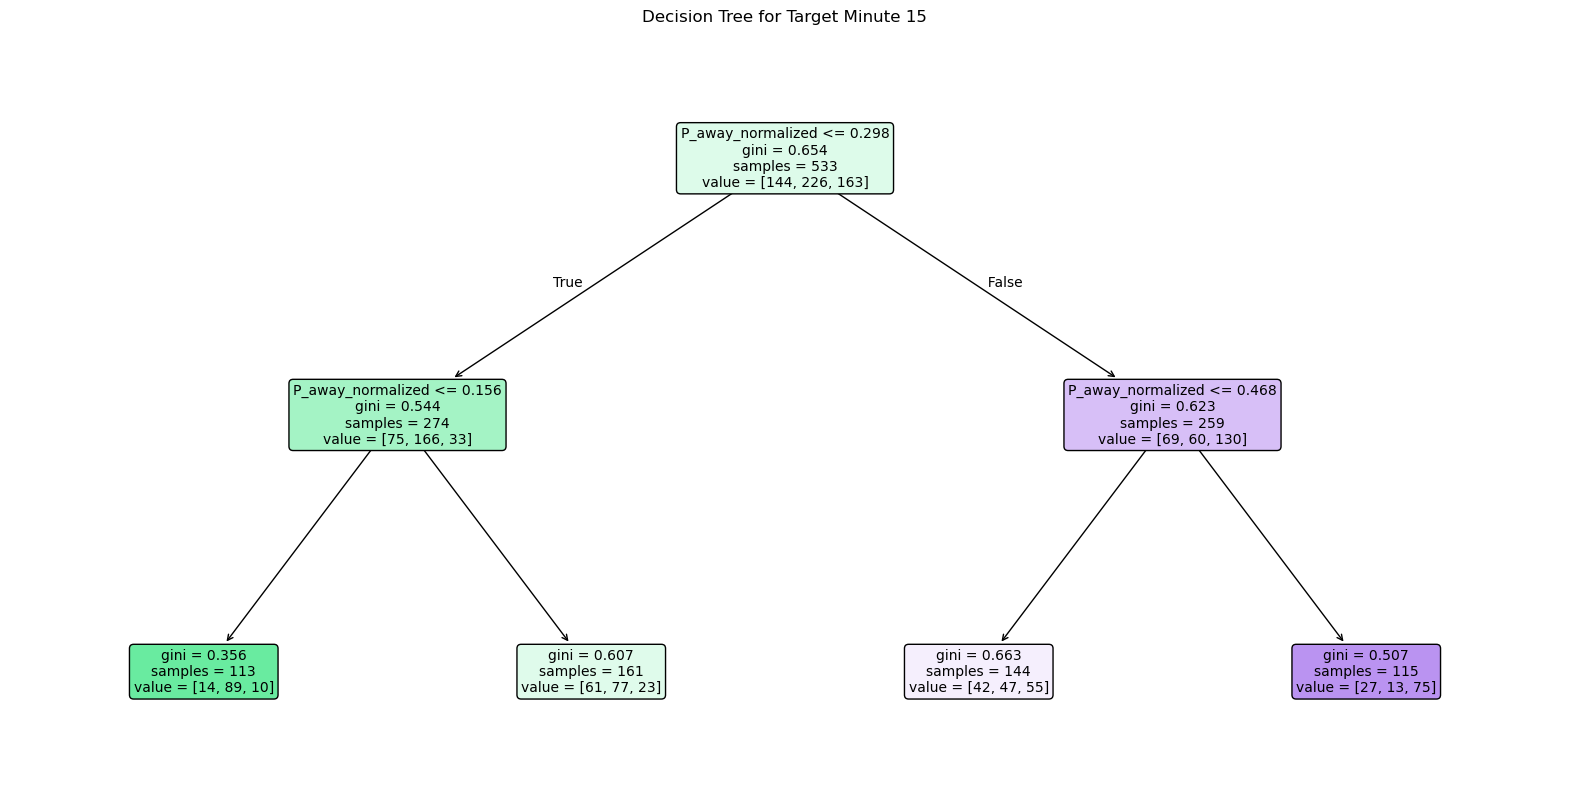

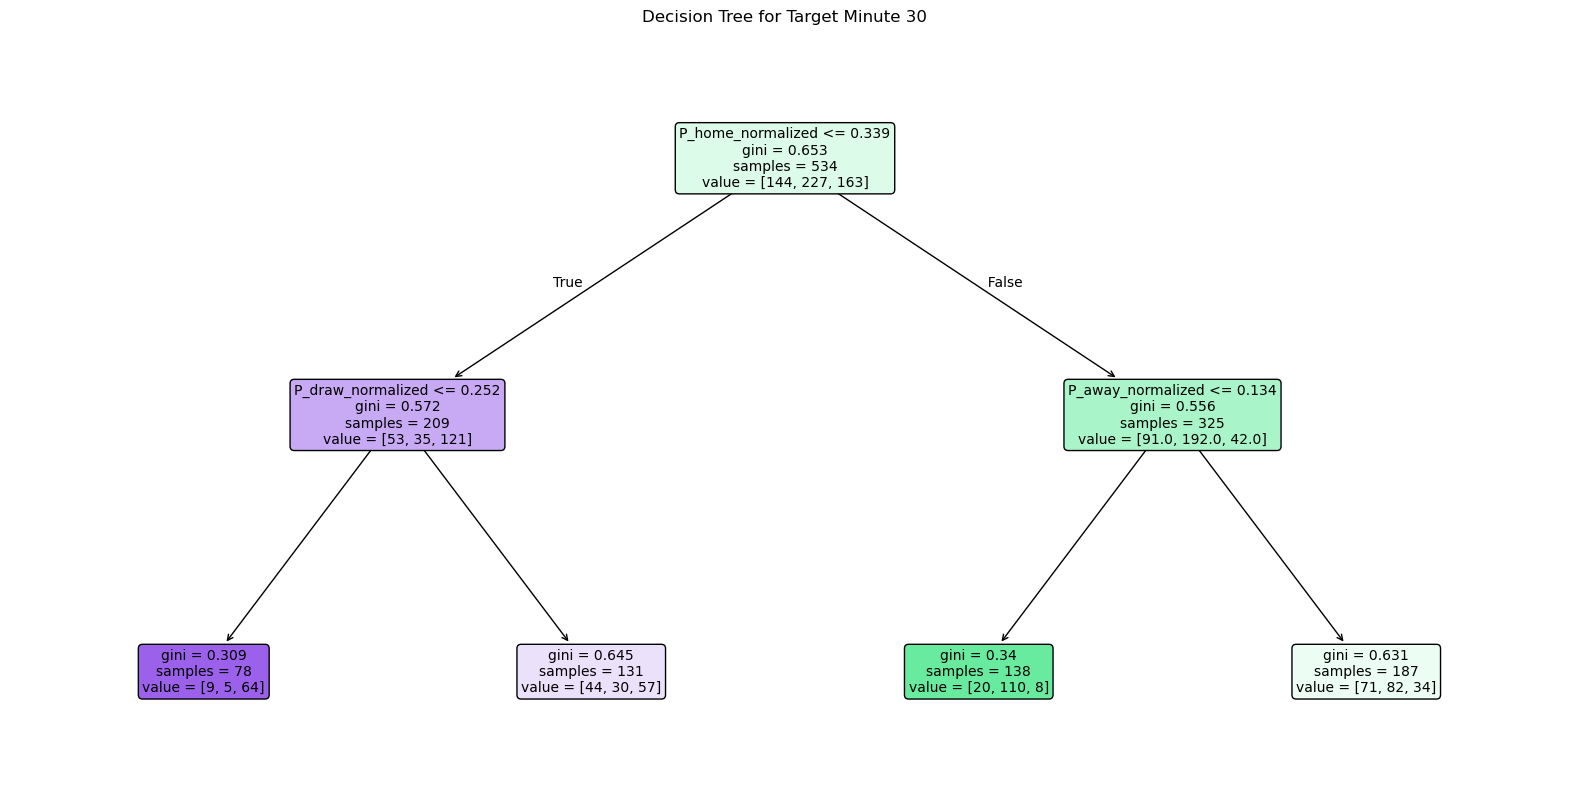

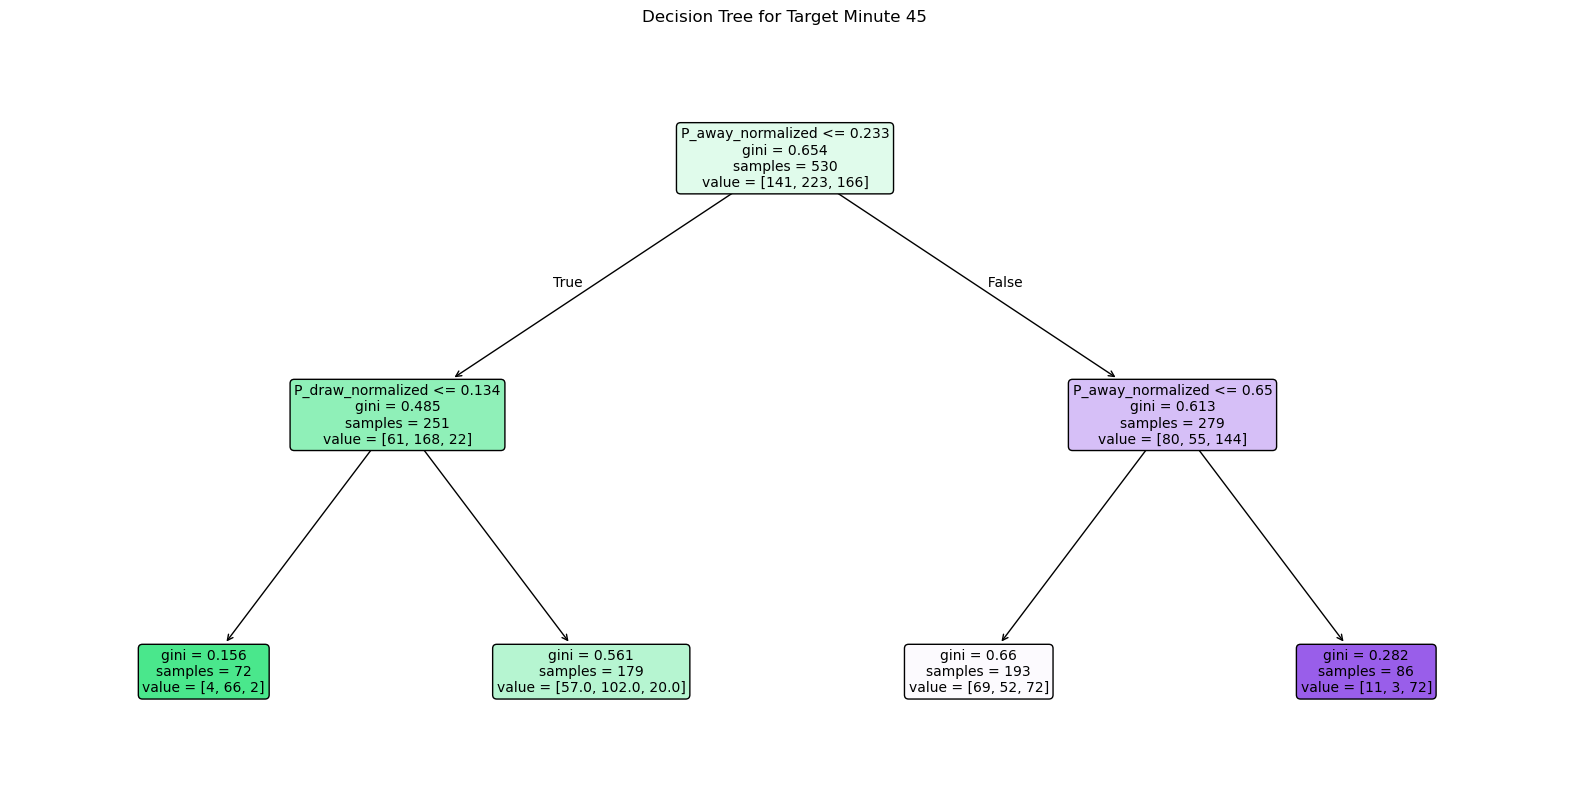

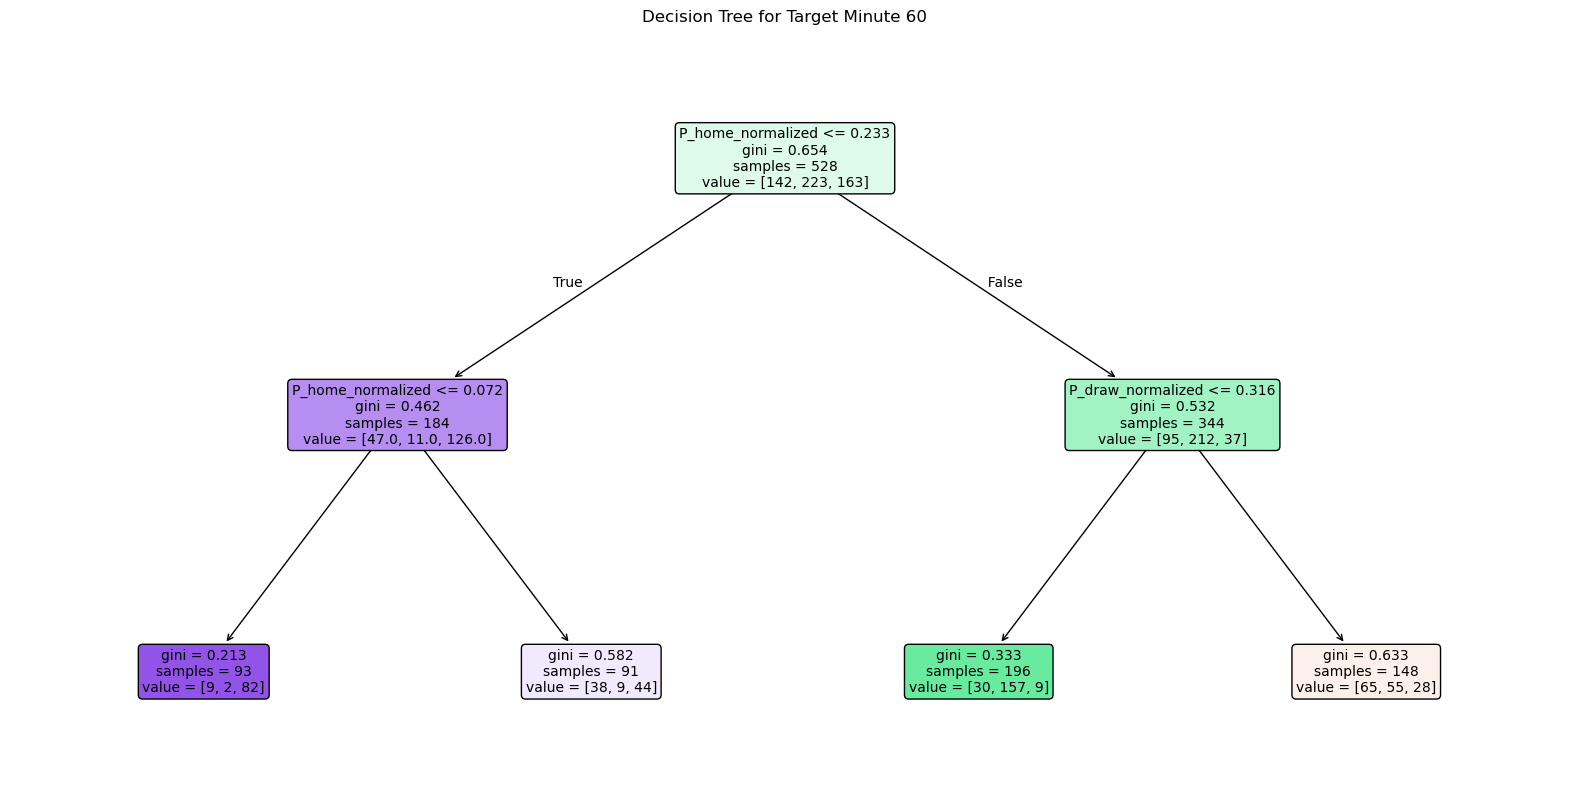

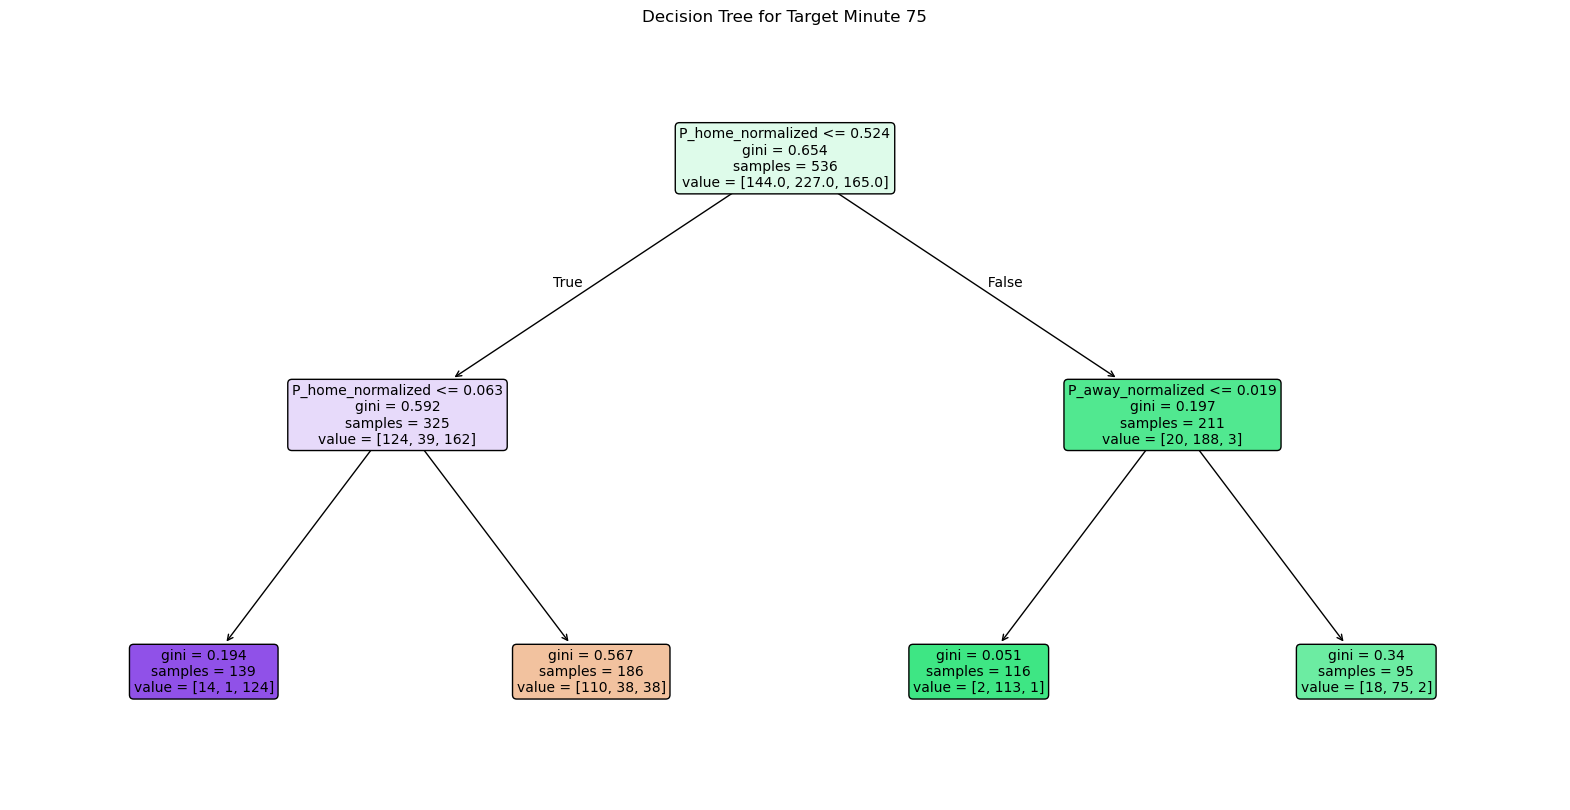

In [15]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Fixed encoding for the 'result' column

trained_trees = {}

# Loop through each target minute
for target in target_minutes:
    # Filter the data for the current target minute
    filtered_df = result_df[result_df['cumulative_minute'] == target].copy()
    
    # Map the 'result' column to numeric values using the fixed mapping
    
    # Encoding the "current_state" feature
    
    # Drop unnecessary columns
    filtered_df = filtered_df.drop(columns=[
        'second', 'fixture_id', 'halftime', 'current_time', 'half_start_datetime',
        'minute', 'second', 'latest_bookmaker_update', 'suspended', 'stopped',
        'name', 'ticking', 'final_score'  
    ])

    # Split into training and testing sets
    train_data = filtered_df[filtered_df["match_start_datetime"] < "2024-11-01"]
    test_data = filtered_df[filtered_df["match_start_datetime"] >= "2024-11-01"]
    
    X_train = train_data.drop(columns=["result", "match_start_datetime"])
    y_train = train_data["result"]
    X_test = test_data.drop(columns=["result", "match_start_datetime"])
    y_test = test_data["result"]
    
    # Train a decision tree for the current target minute
    clf = DecisionTreeClassifier(random_state=42, max_depth=2, min_samples_leaf=40)
    clf.fit(X_train, y_train)
    
    # Store the trained model in the dictionary
    trained_trees[target] = clf
    
    # Plot the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(
    clf,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10
    )
    plt.title(f"Decision Tree for Target Minute {target}")
    plt.show()


chosen max depth = 2 




## strategy 

putting the test data into these trees generated by train data, betting on the nodes where gini <0.35. only betting once for each match, first 15th minute and according tree, then 30th minute etc. 



In [16]:
result_df

fixture_id  halftime         current_time  half_start_datetime  \
15     19134453.0  1st-half  2024-08-16 19:16:18  2024-08-16 19:00:31   
30     19134453.0  1st-half  2024-08-16 19:31:18  2024-08-16 19:00:31   
45     19134453.0  1st-half  2024-08-16 19:46:19  2024-08-16 19:00:31   
60     19134453.0  2nd-half  2024-08-16 20:18:18  2024-08-16 20:02:38   
75     19134453.0  2nd-half  2024-08-16 20:33:18  2024-08-16 20:02:38   
...           ...       ...                  ...                  ...   
63813  19172117.0  1st-half  2024-11-10 16:18:41  2024-11-10 16:03:27   
63828  19172117.0  1st-half  2024-11-10 16:33:41  2024-11-10 16:03:27   
63843  19172117.0  1st-half  2024-11-10 16:48:41  2024-11-10 16:03:27   
63868  19172117.0  2nd-half  2024-11-10 17:31:41  2024-11-10 17:15:56   
63883  19172117.0  2nd-half  2024-11-10 17:46:41  2024-11-10 17:15:56   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
15     2024-08-16 19:00:31      15      47     2024-08-16 19:16:14      False   
30     2024-08-16 19:00:31      30      47     2024-08-16 19:31:17      False   
45     2024-08-16 19:00:31      45      48     2024-08-16 19:46:14      False   
60     2024-08-16 19:00:31      15      40     2024-08-16 20:18:14      False   
75     2024-08-16 19:00:31      30      40     2024-08-16 20:33:13      False   
...                    ...     ...     ...                     ...        ...   
63813  2024-11-10 16:03:27      15      14     2024-11-10 16:18:35      False   
63828  2024-11-10 16:03:27      30      14     2024-11-10 16:33:37      False   
63843  2024-11-10 16:03:27      45      14     2024-11-10 16:48:39      False   
63868  2024-11-10 16:03:27      15      45     2024-11-10 17:31:37      False   
63883  2024-11-10 16:03:27      30      45     2024-11-10 17:46:38      False   

       stopped  ...  Yellowcards - home  Yellowred Cards - away  \
15       False  ...                 0.0                     0.0   
30       False  ...                 1.0                     0.0   
45       False  ...                 2.0                     0.0   
60       False  ...                 2.0                     0.0   
75       False  ...                 2.0                     0.0   
...        ...  ...                 ...                     ...   
63813    False  ...                 0.0                     0.0   
63828    False  ...                 0.0                     0.0   
63843    False  ...                 0.0                     0.0   
63868    False  ...                 0.0                     0.0   
63883    False  ...                 0.0                     0.0   

       Yellowred Cards - home current_state  final_score  result  \
15                        0.0             0          1-0       1   
30                        0.0             0          1-0       1   
45                        0.0             0          1-0       1   
60                        0.0             0          1-0       1   
75                        0.0             0          1-0       1   
...                       ...           ...          ...     ...   
63813                     0.0             0          4-0       1   
63828                     0.0             1          4-0       1   
63843                     0.0             1          4-0       1   
63868                     0.0             1          4-0       1   
63883                     0.0             1          4-0       1   

       P_home_normalized  P_draw_normalized  P_away_normalized  \
15              0.580700           0.249314           0.169987   
30              0.585586           0.269369           0.145045   
45              0.564135           0.302085           0.133780   
60              0.471910           0.393258           0.134831   
75              0.338885           0.517741           0.143374   
...                  ...                ...                ...   
63813           0.785973           0.142684           0.071342   
63828  

In [17]:
test_data = result_df[result_df["match_start_datetime"] >= "2024-11-01"]



In [18]:
minute_results = {}

remaining_matches = test_data.copy()

# for tracking the matches where a bet has already been made
bet_made_matches = set()

# for tracking all fixture IDs 
all_fixture_ids = set(test_data["fixture_id"])

final_results = []

# loop through each target minute
for target in target_minutes:
    # filter rows for the selected minutes
    current_data = remaining_matches[remaining_matches["cumulative_minute"] == target]

    if current_data.empty:
        continue

    # the decision tree trained for the current target minute is used here
    clf = trained_trees[target]

    X_current = current_data.drop(columns=[
        'result', 'fixture_id', 'cumulative_minute', 'match_start_datetime', 
         'halftime', 'current_time', 'half_start_datetime', 
        'minute', 'second', 'latest_bookmaker_update', 'suspended', 'stopped',
        'name', 'ticking', 'current_state', 'final_score'
    ])
    X_current = pd.get_dummies(X_current, drop_first=True)
    X_current = X_current.reindex(columns=clf.feature_names_in_, fill_value=0)

    predictions = clf.predict(X_current)
    node_indices = clf.apply(X_current)

    impurities = clf.tree_.impurity[node_indices]

    current_results = []

    # iterating through each match by aligning indices
    for i, (idx, row) in enumerate(current_data.iterrows()):
        fixture_id = row["fixture_id"]

        # skipping matches if a bet has already been made
        if fixture_id in bet_made_matches:
            continue

        gini = impurities[i]
        if gini < 0.2:
            # make a decision if gini < threshold
            if predictions[i] == 1:
                bet = "home win ('1')"
            elif predictions[i] == 0:
                bet = "draw ('0')"
            elif predictions[i] == 2:
                bet = "away win ('2')"
            decision = f"bet {bet}"
            bet_made_matches.add(fixture_id)
        else:
            # if gini > threshold, no action
            decision = "no action"

        current_results.append({
            "fixture_id": fixture_id,
            "minute": target,
            "decision": decision,
            "gini": gini if gini < 0.2 else None
        })

    current_results_df = pd.DataFrame(current_results)

    no_action_fixture_ids = current_results_df.loc[current_results_df["decision"] == "no action", "fixture_id"]
    remaining_matches = remaining_matches[remaining_matches["fixture_id"].isin(no_action_fixture_ids)]

    final_results.extend(current_results_df[current_results_df["decision"] != "no action"].to_dict("records"))

# assigning "no action" to any remaining matches
for fixture_id in all_fixture_ids - bet_made_matches:
    final_results.append({
        "fixture_id": fixture_id,
        "minute": None,
        "decision": "no action",
        "gini": None,
    })

all_results = pd.DataFrame(final_results)

all_results = all_results.drop_duplicates(subset=["fixture_id"])
print(f"Final Results: {len(all_results)} matches")

print(all_results)


Final Results: 111 matches
     fixture_id  minute            decision      gini
0    19134538.0    45.0  bet home win ('1')  0.155864
1    19135361.0    45.0  bet home win ('1')  0.155864
2    19135369.0    45.0  bet home win ('1')  0.155864
3    19135377.0    45.0  bet home win ('1')  0.155864
4    19139733.0    45.0  bet home win ('1')  0.155864
..          ...     ...                 ...       ...
106  19155169.0     NaN           no action       NaN
107  19155171.0     NaN           no action       NaN
108  19155174.0     NaN           no action       NaN
109  19155181.0     NaN           no action       NaN
110  19155186.0     NaN           no action       NaN

[111 rows x 4 columns]


In [19]:
all_results = all_results.drop_duplicates(subset=["fixture_id"])
all_results

fixture_id  minute            decision      gini
0    19134538.0    45.0  bet home win ('1')  0.155864
1    19135361.0    45.0  bet home win ('1')  0.155864
2    19135369.0    45.0  bet home win ('1')  0.155864
3    19135377.0    45.0  bet home win ('1')  0.155864
4    19139733.0    45.0  bet home win ('1')  0.155864
..          ...     ...                 ...       ...
106  19155169.0     NaN           no action       NaN
107  19155171.0     NaN           no action       NaN
108  19155174.0     NaN           no action       NaN
109  19155181.0     NaN           no action       NaN
110  19155186.0     NaN           no action       NaN

[111 rows x 4 columns]

In [20]:
test_data_unique = test_data.drop_duplicates(subset=["fixture_id"])
test_data_unique

fixture_id  halftime         current_time  half_start_datetime  \
8026   19134533.0  1st-half  2024-11-09 15:16:19  2024-11-09 15:00:47   
8128   19134534.0  1st-half  2024-11-09 17:46:18  2024-11-09 17:30:44   
8230   19134535.0  1st-half  2024-11-10 16:46:18  2024-11-10 16:30:50   
8328   19134536.0  1st-half  2024-11-09 15:16:19  2024-11-09 15:00:53   
8428   19134537.0  1st-half  2024-11-09 20:16:18  2024-11-09 20:01:13   
...           ...       ...                  ...                  ...   
63411  19172113.0  1st-half  2024-11-09 16:18:41  2024-11-09 16:03:23   
63512  19172114.0  1st-half  2024-11-09 10:48:41  2024-11-09 10:33:10   
63613  19172115.0  1st-half  2024-11-08 17:17:41  2024-11-08 17:01:49   
63711  19172116.0  1st-half  2024-11-09 13:18:41  2024-11-09 13:03:21   
63813  19172117.0  1st-half  2024-11-10 16:18:41  2024-11-10 16:03:27   

      match_start_datetime  minute  second latest_bookmaker_update  suspended  \
8026   2024-11-09 15:00:47      15      32     2024-11-09 15:16:11      False   
8128   2024-11-09 17:30:44      15      34     2024-11-09 17:46:09      False   
8230   2024-11-10 16:30:50      15      28     2024-11-10 16:46:16      False   
8328   2024-11-09 15:00:53      15      26     2024-11-09 15:15:53      False   
8428   2024-11-09 20:01:13      15       5     2024-11-09 20:16:11      False   
...                    ...     ...     ...                     ...        ...   
63411  2024-11-09 16:03:23      15      18     2024-11-09 16:18:14      False   
63512  2024-11-09 10:33:10      15      31     2024-11-09 10:48:35      False   
63613  2024-11-08 17:01:49      15      52     2024-11-08 17:17:37      False   
63711  2024-11-09 13:03:21      15      20     2024-11-09 13:18:25      False   
63813  2024-11-10 16:03:27      15      14     2024-11-10 16:18:35      False   

       stopped  ...  Yellowcards - home  Yellowred Cards - away  \
8026     False  ...                 0.0                     0.0   
8128     False  ...                 0.0                     0.0   
8230     False  ...                 0.0                     0.0   
8328     False  ...                 0.0                     0.0   
8428     False  ...                 0.0                     0.0   
...        ...  ...                 ...                     ...   
63411    False  ...                 0.0                     0.0   
63512    False  ...                 0.0                     0.0   
63613    False  ...                 0.0                     0.0   
63711    False  ...                 0.0                     0.0   
63813    False  ...                 0.0                     0.0   

       Yellowred Cards - home current_state  final_score  result  \
8026                      0.0             0          3-2       1   
8128                      0.0             0          2-1       1   
8230                      0.0             0          1-1       0   
8328                      0.0             0          0-2       2   
8428                      0.0             0          2-0       1   
...                       ...           ...          ...     ...   
63411                     0.0             2          0-1       2   
63512                     0.0             2          3-2       1   
63613                     0.0             0          1-2       2   
63711                     0.0             1          3-1       1   
63813                     0.0             0          4-0       1   

       P_home_normalized  P_draw_normalized  P_away_normalized  \
8026            0.313588           0.289466           0.396947   
8128            0.207629           0.249155           0.543216   
8230            0.315152           0.290909           0.393939   
8328            0.268657           0.313433           0.417910   
8428            0.626401           0.216998           0.156600   
...                  ...                ...                ...   
63411           0.103502           0.196109           0.700389   
63512  

In [21]:
##evaulating the betting strategy & calculating the resulting profit

evaluation_df = test_data_unique.merge(all_results, on="fixture_id", how="left")

evaluation_df["profit"] = 0.0
evaluation_df["correct"] = None  

def calculate_profit(row):
    if row["decision"] == "no action":
        return 0, None  # no action: profit = 0, correctness = None
    elif row["decision"] == "bet home win ('1')":
        if row["result"] == 1:  # correct bet
            return row["1"] - 1, 1
        else:  # Incorrect bet
            return -1, 0
    elif row["decision"] == "bet draw ('X')":
        if row["result"] == 0:  # correct bet
            return row["X"] - 1, 1
        else:  # Incorrect bet
            return -1, 0
    elif row["decision"] == "bet away win ('2')":
        if row["result"] == 2:  # correct bet
            return row["2"] - 1, 1
        else:  # Incorrect bet
            return -1, 0
    else:
        return 0, None  # default case for unexpected values

evaluation_df[["profit", "correct"]] = evaluation_df.apply(
    lambda row: pd.Series(calculate_profit(row)), axis=1
)

#  statistics
total_profit = evaluation_df["profit"].sum()
total_bets = evaluation_df[evaluation_df["decision"] != "no action"].shape[0]
total_no_actions = evaluation_df[evaluation_df["decision"] == "no action"].shape[0]
correct_bets = evaluation_df[evaluation_df["correct"] == 1].shape[0]
accuracy = correct_bets / total_bets if total_bets > 0 else 0

print(f"Total Profit from Betting Strategy: {total_profit:.2f} units")
print(f"Total Bets Made: {total_bets}")
print(f"Total No Actions: {total_no_actions}")
print(f"Accuracy of Bets: {accuracy:.2%}")

print(evaluation_df)


Total Profit from Betting Strategy: 37.43 units
Total Bets Made: 60
Total No Actions: 51
Accuracy of Bets: 86.67%
     fixture_id  halftime         current_time  half_start_datetime  \
0    19134533.0  1st-half  2024-11-09 15:16:19  2024-11-09 15:00:47   
1    19134534.0  1st-half  2024-11-09 17:46:18  2024-11-09 17:30:44   
2    19134535.0  1st-half  2024-11-10 16:46:18  2024-11-10 16:30:50   
3    19134536.0  1st-half  2024-11-09 15:16:19  2024-11-09 15:00:53   
4    19134537.0  1st-half  2024-11-09 20:16:18  2024-11-09 20:01:13   
..          ...       ...                  ...                  ...   
106  19172113.0  1st-half  2024-11-09 16:18:41  2024-11-09 16:03:23   
107  19172114.0  1st-half  2024-11-09 10:48:41  2024-11-09 10:33:10   
108  19172115.0  1st-half  2024-11-08 17:17:41  2024-11-08 17:01:49   
109  19172116.0  1st-half  2024-11-09 13:18:41  2024-11-09 13:03:21   
110  19172117.0  1st-half  2024-11-10 16:18:41  2024-11-10 16:03:27   

    match_start_datetime  minute_

In [22]:
all_results.to_csv(f'all_results.csv', index=False)


In [23]:
#X_train.to_csv(f'X_train.csv', index=False)
